In [1]:
import torch
torch.cuda.is_available()

import numpy as np
from scipy.io import loadmat
import h5py

stim_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['stim_full'][0][0]
beh_dat=loadmat('/media/maria/DATA1/Documents/ZebraFish/subject_1/data_full.mat')['data']['Behavior_full'][0][0]
hf = h5py.File('/media/maria/DATA1/Documents/ZebraFish/subject_1/TimeSeries.h5', 'r')
neural_dat=np.array(hf['CellResp'])

In [16]:
import torch
import torchvision
import matplotlib.pyplot as plt

import os, datetime
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

class SparseAutoencoderL1(nn.Module):
    def __init__(self):
        super(SparseAutoencoderL1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(83205, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 83205),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def sparse_loss(autoencoder, images):
    loss = 0
    values = images
    for i in range(3):
        fc_layer = list(autoencoder.encoder.children())[2 * i]
        relu = list(autoencoder.encoder.children())[2 * i + 1]
        values = relu(fc_layer(values))
        loss += torch.mean(torch.abs(values))
    for i in range(2):
        fc_layer = list(autoencoder.decoder.children())[2 * i]
        relu = list(autoencoder.decoder.children())[2 * i + 1]
        values = relu(fc_layer(values))
        loss += torch.mean(torch.abs(values))
    return loss

def model_training(autoencoder, train_loader, epoch):
    loss_metric = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    autoencoder.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        mse_loss = loss_metric(outputs, images)
        l1_loss = sparse_loss(autoencoder, images)
        loss = mse_loss + SPARSE_REG * l1_loss
        loss.backward()
        optimizer.step()
        if (i + 1) % LOG_INTERVAL == 0:
            print('Epoch [{}/{}] - Iter[{}/{}], Total loss:{:.4f}, MSE loss:{:.4f}, Sparse loss:{:.4f}'.format(
                epoch + 1, EPOCHS, i + 1, len(train_loader.dataset) // BATCH_SIZE, loss.item(), mse_loss.item(), l1_loss.item()
            ))

def evaluation(autoencoder, test_loader):
    total_loss = 0
    loss_metric = nn.MSELoss()
    autoencoder.eval()
    for i, data in enumerate(test_loader):
        images = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder(images)
        loss = loss_metric(outputs, images)
        total_loss += loss * len(images)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))

    global BEST_VAL
    if TRAIN_SCRATCH and avg_loss < BEST_VAL:
        BEST_VAL = avg_loss
        #torch.save(autoencoder.state_dict(), './history/sparse_autoencoder_l1.pt')
        print('Save Best Model in HISTORY\n')


if __name__ == '__main__':

    EPOCHS = 10
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    LOG_INTERVAL = 100
    SPARSE_REG = 1e-3
    TRAIN_SCRATCH = True        # whether to train a model from scratch
    BEST_VAL = float('inf')
    
    autoencoder = SparseAutoencoderL1()
    if cuda: autoencoder.to(device)
    x_train,x_test,stim_train,stim_test=train_test_split(neural_dat,stim_dat.flatten(), test_size=0.33, random_state=42)
    train_loader = DataLoader(x_train, batch_size=4,
                        shuffle=True, num_workers=4)
    test_loader = DataLoader(x_test, batch_size=1,
                        shuffle=False, num_workers=4)
    if TRAIN_SCRATCH:
        # Training autoencoder from scratch
        for epoch in range(EPOCHS):
            starttime = datetime.datetime.now()
            model_training(autoencoder, train_loader, epoch)
            endtime = datetime.datetime.now()
            print(f'Train a epoch in {(endtime - starttime).seconds} seconds')
            
            # evaluate on test set and save best model
            evaluation(autoencoder, test_loader)
            #utput=autoencoder(neural_dat.to_device(device))
        print('Trainig Complete with best validation loss {:.4f}'.format(BEST_VAL))

Epoch [1/10] - Iter[100/15], Total loss:0.0201, MSE loss:0.0198, Sparse loss:0.2977
Epoch [1/10] - Iter[200/15], Total loss:0.0187, MSE loss:0.0184, Sparse loss:0.2373
Epoch [1/10] - Iter[300/15], Total loss:0.0279, MSE loss:0.0270, Sparse loss:0.8246
Epoch [1/10] - Iter[400/15], Total loss:0.0175, MSE loss:0.0173, Sparse loss:0.2793
Train a epoch in 10 seconds

Average MSE Loss on Test set: 0.0242
Save Best Model in HISTORY

Epoch [2/10] - Iter[100/15], Total loss:0.0207, MSE loss:0.0202, Sparse loss:0.5020
Epoch [2/10] - Iter[200/15], Total loss:0.0209, MSE loss:0.0206, Sparse loss:0.3108
Epoch [2/10] - Iter[300/15], Total loss:0.0196, MSE loss:0.0194, Sparse loss:0.2144
Epoch [2/10] - Iter[400/15], Total loss:0.0191, MSE loss:0.0188, Sparse loss:0.2179
Train a epoch in 11 seconds

Average MSE Loss on Test set: 0.0240
Save Best Model in HISTORY

Epoch [3/10] - Iter[100/15], Total loss:0.0224, MSE loss:0.0222, Sparse loss:0.2125
Epoch [3/10] - Iter[200/15], Total loss:0.0231, MSE loss

In [17]:
total_loader = DataLoader(neural_dat, batch_size=1,
                        shuffle=False, num_workers=4)

In [18]:
lst=[]
for i, data in enumerate(total_loader):
        images = data
        images = Variable(images)
        images = images.view(images.size(0), -1)
        if cuda: images = images.to(device)
        outputs = autoencoder.encoder(images)
        nps=outputs.cpu().detach().numpy()
        lst.append(nps)
lst=np.array(lst)
print(lst.shape)

(2880, 1, 32)


ValueError: 'c' argument has 1 elements, which is not acceptable for use with 'x' with size 2880, 'y' with size 2880.

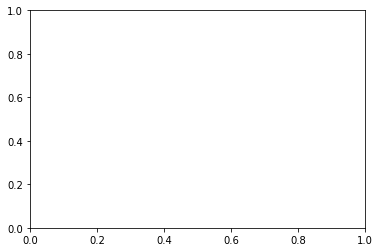

In [20]:
dat=lst.reshape(-1,32)
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pcs=pca.fit_transform(dat)
import matplotlib.pyplot as plt
plt.scatter(pcs[:,0],pcs[:,1],c=dat_sti)